# Saliency to Explain Edge Cases

This demo demonstrates the use of the `xaitk_saliency` package to provide useful explanations for the performance of an object detection model.
Specifically, we examine instances where the decisions the model makes are questionable.
Saliency maps can provide useful insights into why the model behaved in an unexpected way.

In [1]:
# Download dependencies
!pip install -q xaitk_saliency[tools]
!pip install -q smqtk_detection[centernet]
# Remove opencv-python, which required libGL, which we don't require here, and replace with opencv-python-headless
!pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!pip install -q opencv-python-headless

# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

## Detection Model

The `CenterNetVisdrone` class from `smqtk-detection` is a wrapper around a PyTorch-based CenterNet Model pretrained on the VisDrone2019 dataset.
Our implementation uses a ResNet50 backbone.

The [CenterNet model](https://arxiv.org/pdf/1904.07850.pdf) is a single-stage detector that represents objects as a single point, the center of its bounding box.
This architecture uses a common backbone to extract features from an image, followed by a number of parallel heads that each regress different keypoints using these features.
For object detection, these keypoints are the object's center, an offset, and the size of its bounding box.

The center heatmap output of this model can be pooled to remove repeated predictions **before** the bounding boxes are decoded.
This largely eliminates the need for a costly non-max suppression operation and gives CenterNet an advantage over other single-stage approaches.
<p align="center">
  <img src=https://miro.medium.com/max/1400/1*y82flEmdWr20NjuevgQ8-Q.png />
  <img src=https://cdn-ak.f.st-hatena.com/images/fotolife/u/uiiurz1/20190519/20190519182844.png />
</p>

</br>

The [VisDrone dataset](https://arxiv.org/pdf/1804.07437v2.pdf) contains 265,288 frames and 10,209 static images captured by drone-mounted cameras covering a wide variety of environments, objects, and densities.
It has over 2.6 million annotated bounding boxes for 10 different categories including pedestrians, cars, trucks, vans, buses, bikes, and motorcycles.

<img src=https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-66823-5_42/MediaObjects/509618_1_En_42_Fig1_HTML.png />
    


In [2]:
import os
import urllib

from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone

import logging
logging.basicConfig(level=logging.INFO)

data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# download weights
model_file = os.path.join(data_dir, 'centernet-resnet50.pth')
urllib.request.urlretrieve('https://data.kitware.com/api/v1/file/61e8288d4acac99f426fead2/download', model_file)

detector = CenterNetVisdrone(
    arch='resnet50',
    model_file='data/centernet-resnet50.pth',
    max_dets=500,
    use_cuda=True,
    batch_size=3
)

INFO:smqtk_detection.impls.detect_image_objects.centernet:=> loading pretrained model https://download.pytorch.org/models/resnet50-19c8e357.pth
INFO:smqtk_detection.impls.detect_image_objects.centernet:loaded data/centernet-resnet50.pth, epoch 100


## Detections of Interest

An outside process generated these detections of interest made by the CenterNet model and serialized them using the COCO format.

`kwcoco` is a package that provides a robust set of load and query tools for COCO style annotations.
We use it here to create a dataset object containing our detections.

In [3]:
import os
import urllib
import kwcoco

data_dir = 'data'
coco_preds_fpath = os.path.join(data_dir, 'edge_predictions.json')
coco_gt_fpath = os.path.join(data_dir, 'edge_gt.json')

urllib.request.urlretrieve('https://data.kitware.com/api/v1/item/61f46cb84acac99f42f7be93/download', coco_preds_fpath)
urllib.request.urlretrieve('https://data.kitware.com/api/v1/item/61f46cbf4acac99f42f7bea1/download', coco_gt_fpath)

pred_dset = kwcoco.CocoDataset(coco_preds_fpath)
gt_dset = kwcoco.CocoDataset(coco_gt_fpath)

## Misclassification

The first two predictions are examples of misclassification.
The VisDrone "pedestrian" class refers to a human that "maintains a standing pose or is walking", otherwise humans are labeled as "people".
Our detector predicted the first example as "pedestrian" although the person is sitting on a bench and labeled as such in the ground truth.
The second example is a person standing next to a motorbike that is incorrectly predicted as "people", again differing from the ground truth.

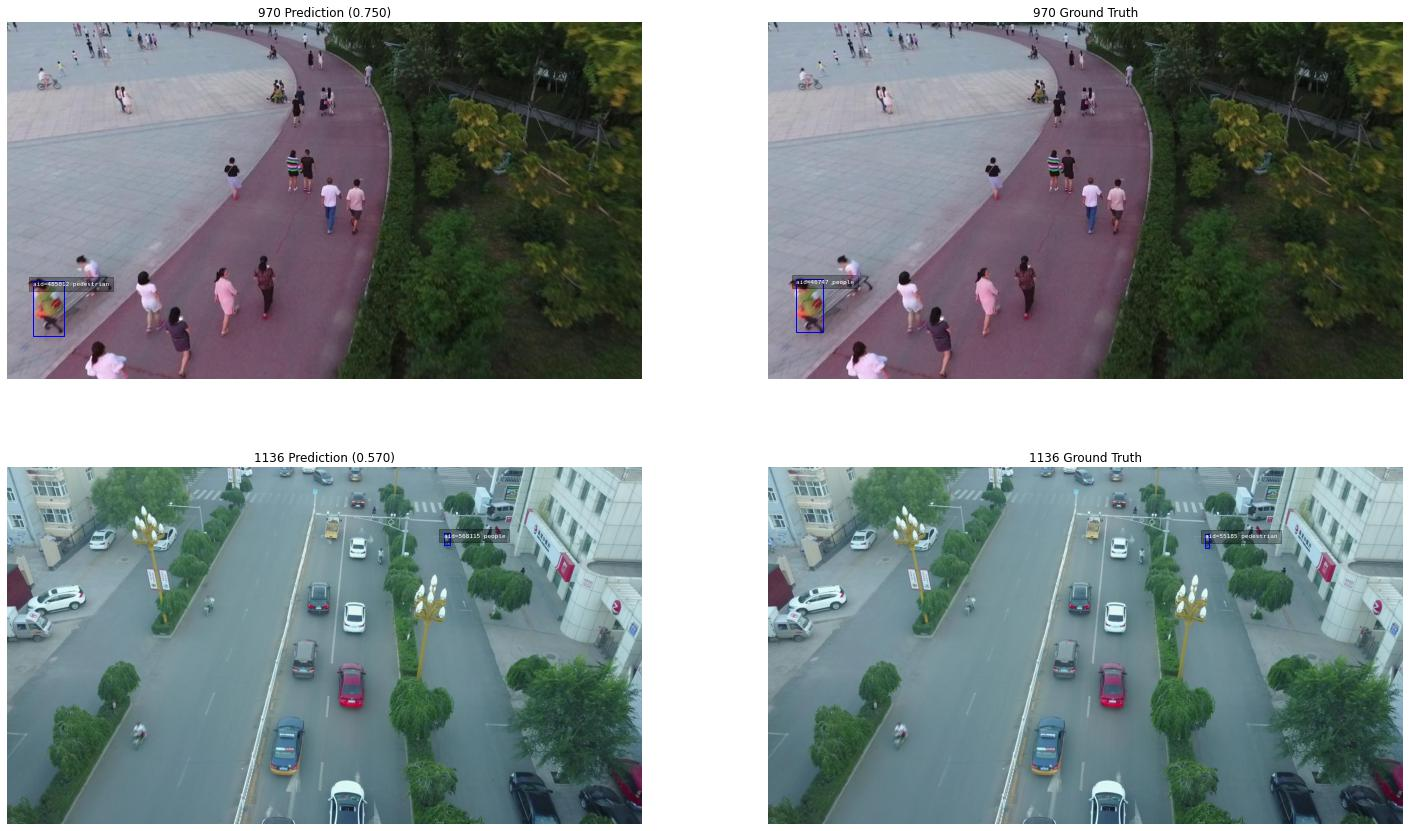

In [4]:
import matplotlib.pyplot as plt

img_ids = [970, 1136]

fig, axs = plt.subplots(2, 2, figsize=(25,15))

subplot_idx = 1

for img_id in img_ids:
    detection_id = next(iter(pred_dset.gid_to_aids[img_id]))
    score = pred_dset.anns[detection_id]['score']
    plt.subplot(2, 2, subplot_idx)
    subplot_idx += 1
    pred_dset.show_image(
        img_id,
        title="{:d} Prediction ({:.3f})".format(img_id, score),
        show_gid=False,
        show_filename=False,
        show_segmentation=False
    )
    plt.axis('off')
    
    plt.subplot(2, 2, subplot_idx)
    subplot_idx += 1
    gt_dset.show_image(
        img_id,
        title=f"{img_id} Ground Truth",
        show_gid=False,
        show_filename=False,
        show_segmentation=False
    )
    plt.axis('off')

## Spurious Detection

The next example shows a prediction made by the model that is not present in the ground truth, i.e. the model mistaking a feature of the image as an object.
In this case, the side of a building is detected as a truck with relatively high confidence.

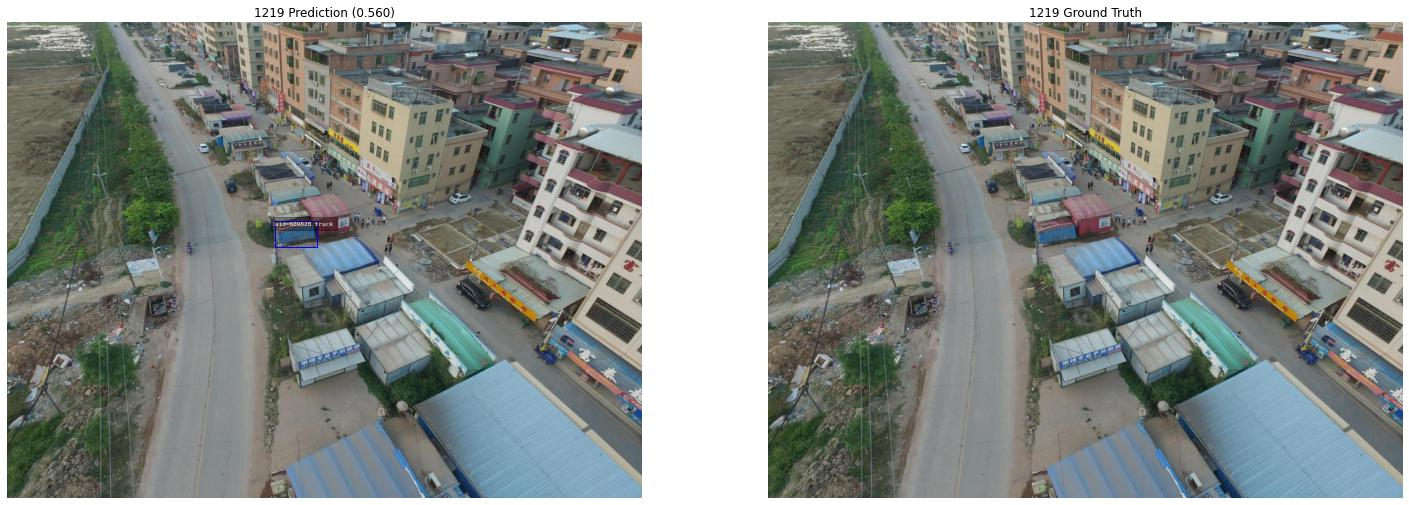

In [5]:
img_id = 1219

fig, axs = plt.subplots(1, 2, figsize=(25,25))

detection_id = next(iter(pred_dset.gid_to_aids[img_id]))
score = pred_dset.anns[detection_id]['score']

plt.subplot(1, 2, 1)
subplot_idx += 1
pred_dset.show_image(
    img_id,
    title="{:d} Prediction ({:.3f})".format(img_id, score),
    show_gid=False,
    show_filename=False,
    show_segmentation=False
)
plt.axis('off')

plt.subplot(1, 2, 2)
subplot_idx += 1
gt_dset.show_image(
    img_id,
    title=f"{img_id} Ground Truth",
    show_gid=False,
    show_filename=False,
    show_segmentation=False
)
_ = plt.axis('off')

## Mislocalization

Finally, we show a prediction that's bounding box is considerably offset from the ground truth.
Most of this car is obstructed by the roof of the building, but the predicted bounding box extends past the visible portion of the car.

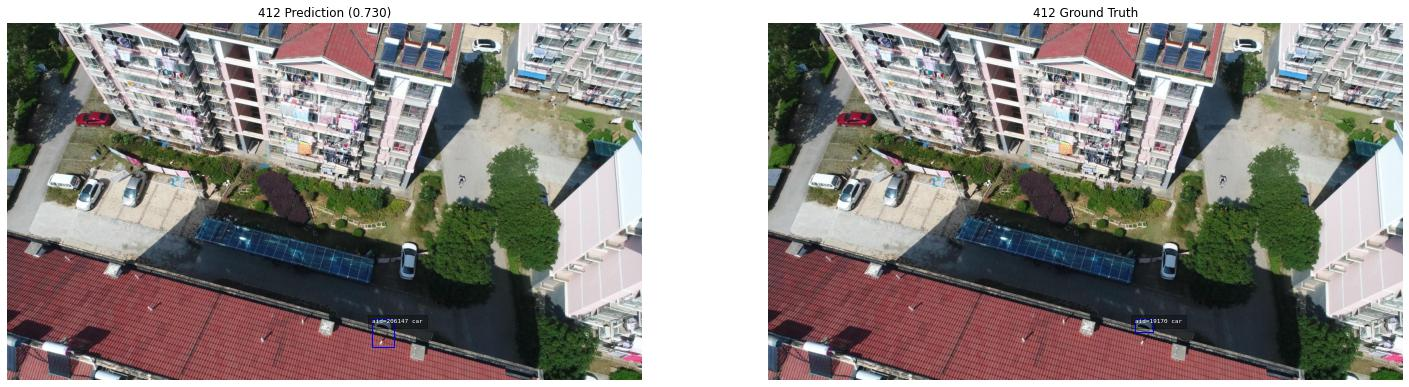

In [6]:
img_id = 412

fig, axs = plt.subplots(1, 2, figsize=(25,25))

detection_id = next(iter(pred_dset.gid_to_aids[img_id]))
score = pred_dset.anns[detection_id]['score']

plt.subplot(1, 2, 1)
subplot_idx += 1
pred_dset.show_image(
    img_id,
    title="{:d} Prediction ({:.3f})".format(img_id, score),
    show_gid=False,
    show_filename=False,
    show_segmentation=False
)
plt.axis('off')

plt.subplot(1, 2, 2)
subplot_idx += 1
gt_dset.show_image(
    img_id,
    title=f"{img_id} Ground Truth",
    show_gid=False,
    show_filename=False,
    show_segmentation=False
)
_ = plt.axis('off')

## Configuration of Algorithms with Explanations

The [D-RISE algorithm](https://arxiv.org/pdf/2006.03204.pdf) generates visual saliency maps for predictions made by an object detector.
It does so by measuring the effect of masking randomized regions of the input and using the changes in the detector's output to determine the importance of those regions.
This approach is "black-box" as it is analyzing only the inputs and outputs of the detector.

<img src=https://cs-people.bu.edu/vpetsiuk/drise/drise-overview.jpg />

Configuration of the image perturbation algorithm is crucial to the quality of your saliency maps.
`RISE` has three parameters:
- `n` : the number of masks to use
- `s` : the masking grid size
- `p1` : the probability that a grid cell will be occluded

Increasing number of masks will result in less noise in the final saliency map while also increasing the computation resources needed, as each perturbed image needs to be passed through our model.
For our detections, we will use 500 masks to obtain a good balance of low noise and reasonable computation time.

The grid size will affect the granularity of the saliency map.
This should partially be gauged based on the size of the objects in the camera frame.
In general, a finer-grained saliency map can reveal more detailed information.
Due to the small size of the objects in our data, we need to use a fairly high grid size to obtain meaningful saliency maps.
An `s` value of 64 will suffice here.

In [7]:
from xaitk_saliency.impls.perturb_image.rise import RISEGrid
from xaitk_saliency.impls.gen_detector_prop_sal.drise_scoring import DRISEScoring

image_perturber = RISEGrid(n=500, s=64, p1=0.5)
sal_generator = DRISEScoring()

## Generate Saliency Maps

Using the `gen_coco_sal()` function from `xaitk_saliency`, we can generate saliency maps for our detections using our CenterNet model and the perturbation/saliency algorithms that we configured.

In [8]:
from xaitk_saliency.utils.gen_coco_sal import gen_coco_sal
import time

start = time.time()

sal_maps = gen_coco_sal(pred_dset, detector, image_perturber, sal_generator, verbose=True)

end = time.time()
print("Elapsed time: %0.2fs" %(end-start))

INFO:xaitk_saliency.utils.gen_coco_sal:[412] (1/4) 1 reference detections found.
INFO:xaitk_saliency.utils.gen_coco_sal:[412] (1/4) Perturbing image.
INFO:xaitk_saliency.utils.gen_coco_sal:[412] (1/4) Getting perturbation detections.
INFO:smqtk_detection.impls.detect_image_objects.centernet:[1/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[2/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[3/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[4/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[5/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[6/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[7/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[8/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[9/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[10/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[11/167]
INFO:smqtk_detection.impls.detect_imag

INFO:smqtk_detection.impls.detect_image_objects.centernet:[120/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[121/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[122/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[123/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[124/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[125/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[126/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[127/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[128/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[129/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[130/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[131/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[132/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[133/167]
INFO:smqtk_detection.impls.detect_image_objects.

INFO:smqtk_detection.impls.detect_image_objects.centernet:[71/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[72/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[73/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[74/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[75/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[76/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[77/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[78/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[79/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[80/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[81/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[82/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[83/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[84/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[85/

INFO:smqtk_detection.impls.detect_image_objects.centernet:[21/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[22/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[23/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[24/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[25/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[26/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[27/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[28/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[29/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[30/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[31/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[32/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[33/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[34/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[35/

INFO:smqtk_detection.impls.detect_image_objects.centernet:[143/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[144/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[145/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[146/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[147/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[148/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[149/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[150/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[151/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[152/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[153/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[154/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[155/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[156/167]
INFO:smqtk_detection.impls.detect_image_objects.

INFO:smqtk_detection.impls.detect_image_objects.centernet:[94/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[95/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[96/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[97/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[98/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[99/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[100/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[101/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[102/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[103/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[104/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[105/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[106/167]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[107/167]
INFO:smqtk_detection.impls.detect_image_objects.center

Elapsed time: 1506.85s


## Misclassification Explanation

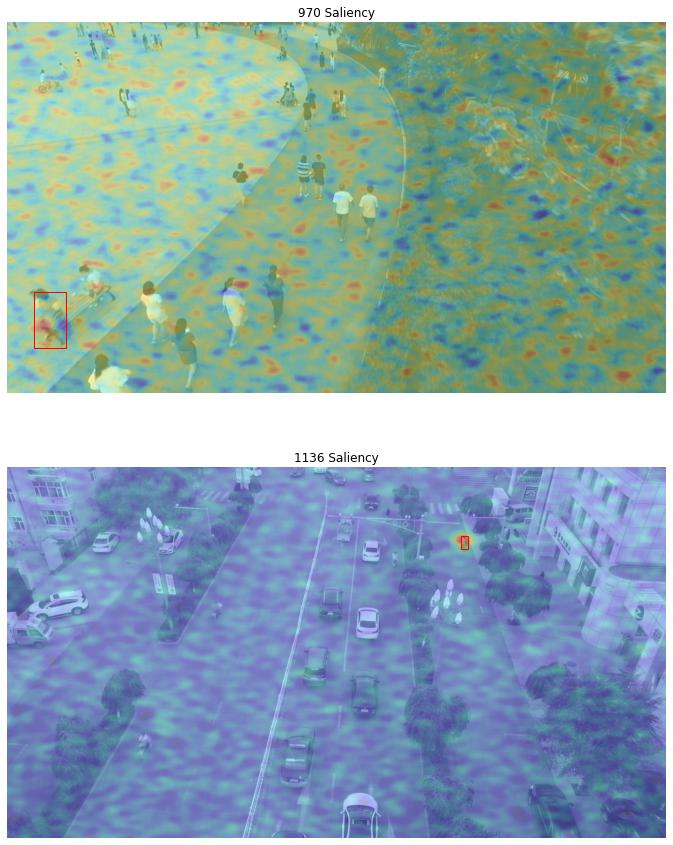

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

img_ids = [970, 1136]

fig, axs = plt.subplots(2, 1, figsize=(25,15))

for img_idx, img_id in enumerate(img_ids):
    detection_id = next(iter(pred_dset.gid_to_aids[img_id]))
    img = pred_dset.load_image(img_id)
    plt.subplot(2, 1, img_idx+1)
    plt.axis('off')
    gray_img = np.asarray(Image.fromarray(img).convert("L"))
    plt.imshow(gray_img, alpha=0.7, cmap='gray')

    bbox = pred_dset.anns[detection_id]['bbox']
    plt.gca().add_patch(Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    ))
    plt.imshow(sal_maps[detection_id], cmap='jet', alpha=0.3)
    plt.title(f"{img_id} Saliency")

## Spurious Detection Explanation

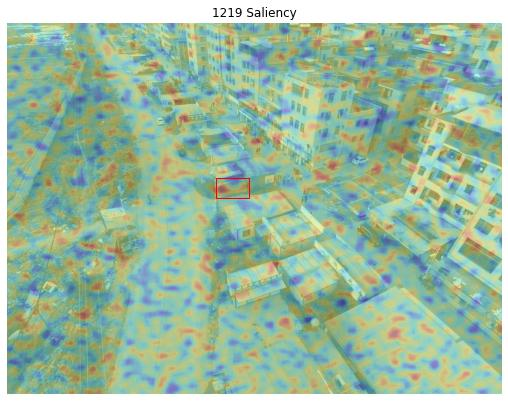

In [10]:
img_id = 1219

fig = plt.figure(figsize=(15,15))

detection_id = next(iter(pred_dset.gid_to_aids[img_id]))
img = pred_dset.load_image(img_id)
plt.subplot(2, 1, img_idx+1)
plt.axis('off')
gray_img = np.asarray(Image.fromarray(img).convert("L"))
plt.imshow(gray_img, alpha=0.7, cmap='gray')

bbox = pred_dset.anns[detection_id]['bbox']
plt.gca().add_patch(Rectangle(
    (bbox[0], bbox[1]),
    bbox[2],
    bbox[3],
    linewidth=1,
    edgecolor='r',
    facecolor='none'
))
plt.imshow(sal_maps[detection_id], cmap='jet', alpha=0.3)
_ = plt.title(f"{img_id} Saliency")

## Mislocalization Explanation

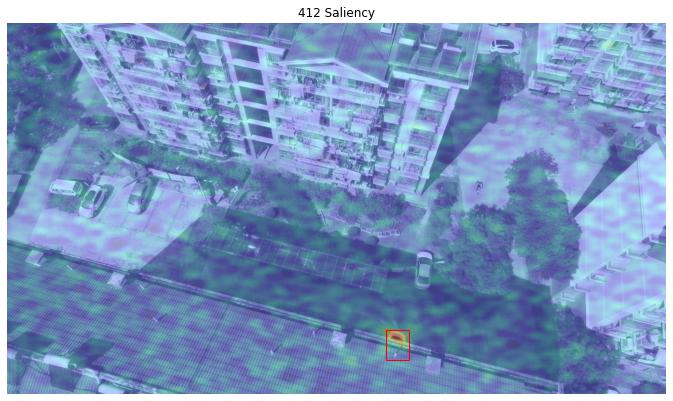

In [11]:
img_id = 412

fig = plt.figure(figsize=(15,15))

detection_id = next(iter(pred_dset.gid_to_aids[img_id]))
img = pred_dset.load_image(img_id)
plt.subplot(2, 1, img_idx+1)
plt.axis('off')
gray_img = np.asarray(Image.fromarray(img).convert("L"))
plt.imshow(gray_img, alpha=0.7, cmap='gray')

bbox = pred_dset.anns[detection_id]['bbox']
plt.gca().add_patch(Rectangle(
    (bbox[0], bbox[1]),
    bbox[2],
    bbox[3],
    linewidth=1,
    edgecolor='r',
    facecolor='none'
))
plt.imshow(sal_maps[detection_id], cmap='jet', alpha=0.3)
_ = plt.title(f"{img_id} Saliency")